In [132]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [133]:
# Load data
users = pd.read_csv("data/users.csv", parse_dates=["signup_date"])
events = pd.read_csv("data/events.csv", parse_dates=["timestamp"])

# Preview
print(users.head())
print(events['event_type'].value_counts())

  user_id signup_date device_type country
0  user_1  2024-03-22     desktop      US
1  user_2  2024-01-15      tablet      US
2  user_3  2024-01-04      mobile      US
3  user_4  2024-04-04      mobile      CA
4  user_5  2024-02-05     desktop      DE
event_type
login           1826
click            956
verify_email     898
signup           466
upgrade          415
Name: count, dtype: int64


In [134]:
funnel_steps = ['signup', 'verify_email', 'login', 'upgrade']

# Filter to funnel-related events
funnel_events = events[events['event_type'].isin(funnel_steps)]

# Count how many unique users completed each step
funnel_counts = funnel_events.groupby('event_type')['user_id'].nunique().reindex(funnel_steps)

print(funnel_counts)

event_type
signup          299
verify_email    408
login           475
upgrade         275
Name: user_id, dtype: int64


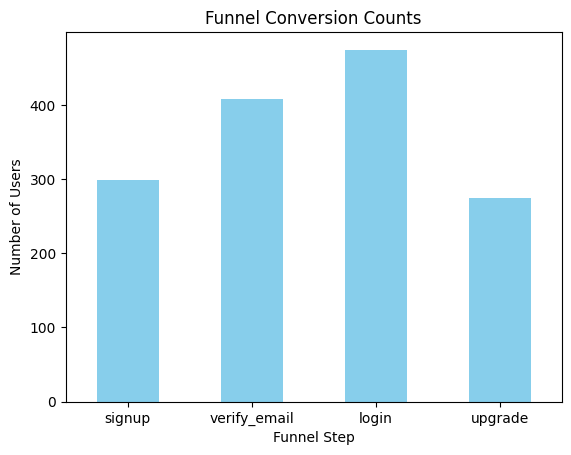

In [135]:

funnel_counts.plot(kind='bar', color='skyblue')
plt.title("Funnel Conversion Counts")
plt.ylabel("Number of Users")
plt.xlabel("Funnel Step")
plt.xticks(rotation=0)
plt.show()

In [136]:
# Merge signup_date into events
events = events.merge(users[['user_id', 'signup_date']], on='user_id')

# Calculate days since signup
events['days_since_signup'] = (events['timestamp'] - events['signup_date']).dt.days

# Focus on login events for retention
logins = events[(events['event_type'] == 'login') & (events['days_since_signup'].isin([1, 7, 30]))]

# Count unique users per retention bucket
retention_counts = logins.groupby('days_since_signup')['user_id'].nunique().reindex([1, 7, 30])
print(retention_counts)

days_since_signup
1     52
7     51
30    43
Name: user_id, dtype: int64


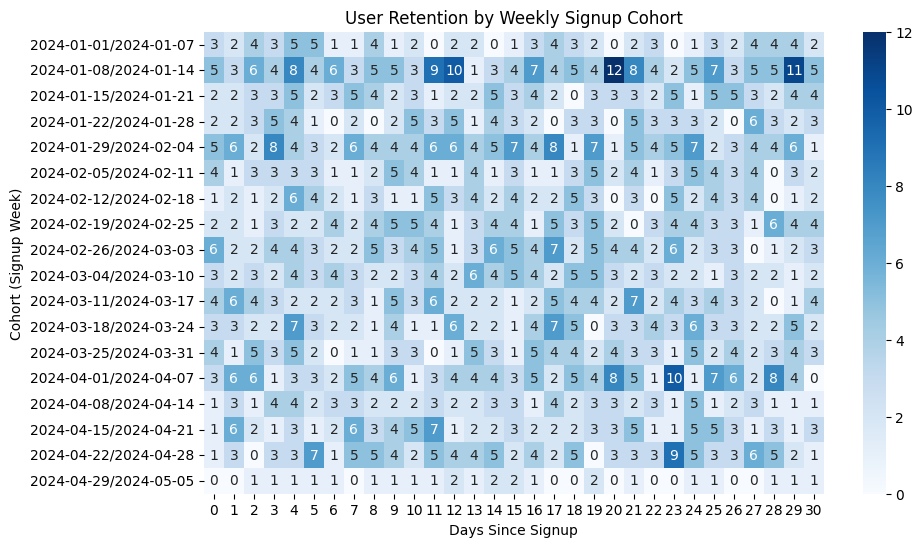

In [137]:
events['cohort'] = events['signup_date'].dt.to_period('W').astype(str)
cohort_retention = events[events['event_type'] == 'login']
cohort_retention = cohort_retention.groupby(['cohort', 'days_since_signup'])['user_id'].nunique().unstack(fill_value=0)

plt.figure(figsize=(10,6))
sns.heatmap(cohort_retention, cmap="Blues", annot=True, fmt="d")
plt.title("User Retention by Weekly Signup Cohort")
plt.ylabel("Cohort (Signup Week)")
plt.xlabel("Days Since Signup")
plt.show()

In [138]:
import sqlite3

# Create SQLite connection
conn = sqlite3.connect(":memory:")

# Load DataFrames into SQL tables
users.to_sql("users", conn, index=False, if_exists="replace")
events.to_sql("events", conn, index=False, if_exists="replace")

4561

In [139]:
query = """
SELECT event_type,
       COUNT(DISTINCT user_id) AS user_count
FROM events
WHERE event_type IN ('signup', 'verify_email', 'login', 'upgrade')
GROUP BY event_type
ORDER BY CASE event_type
    WHEN 'signup' THEN 1
    WHEN 'verify_email' THEN 2
    WHEN 'login' THEN 3
    WHEN 'upgrade' THEN 4
END
"""
retention_kpis = pd.read_sql(query, conn)
retention_kpis

,event_type,user_count
0,signup,299
1,verify_email,408
2,login,475
3,upgrade,275


In [140]:
pd.read_sql("SELECT * FROM users LIMIT 5", conn)

,user_id,signup_date,device_type,country
0,user_1,2024-03-22 00:00:00,desktop,US
1,user_2,2024-01-15 00:00:00,tablet,US
2,user_3,2024-01-04 00:00:00,mobile,US
3,user_4,2024-04-04 00:00:00,mobile,CA
4,user_5,2024-02-05 00:00:00,desktop,DE
